In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
plt.style.use('seaborn-whitegrid')
from sklearn.model_selection import cross_val_score
RANDOM_SEED = 67

In [2]:
data = pd.read_csv('insurance_claims.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

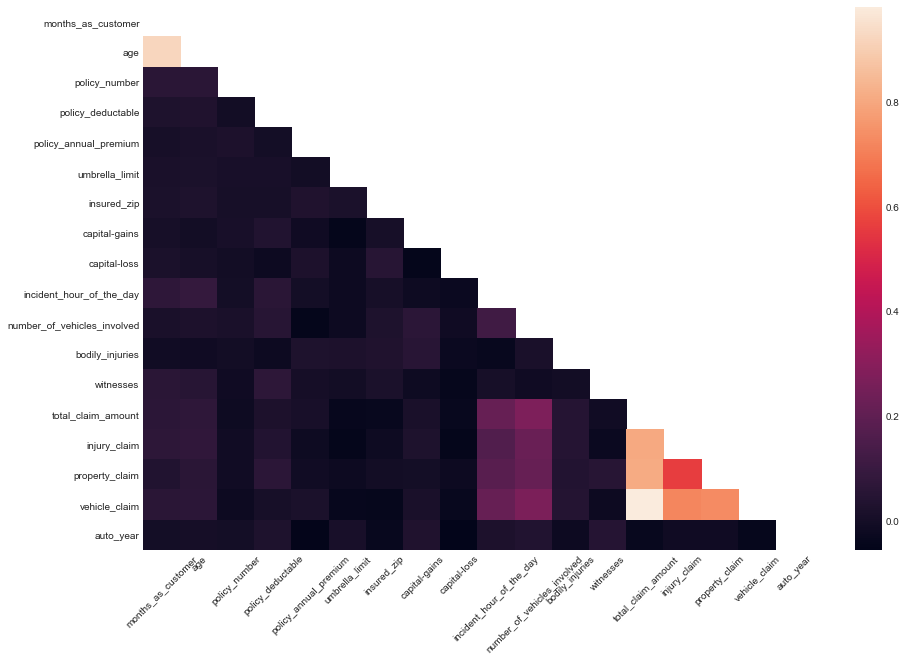

In [3]:
plt.figure(figsize=(15,10)) 
mask = np.triu(np.ones_like(data.corr()))
dataplot = sns.heatmap(data.corr(), mask=mask)
plt.xticks(rotation=45)
plt.show()

In [4]:
#удаляем данные, которые имеют высокую корелляцию, оставим только величину итоговой выплаты
data.drop(['injury_claim','property_claim','vehicle_claim'], axis = 1, inplace = True)


## Preprocessing

In [5]:
data.select_dtypes(include=[object]).head(3)#21 столбец категориальных данных, как это это слишком много
#пока что давайте переведем их в числа с помощью label encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data[data.select_dtypes(include=[object]).columns] = data[data.select_dtypes(include=[object]).columns].apply(le.fit_transform)
data.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,532,2,1,1000,1406.91,0,466132,...,1,2,1,2,2,71610,10,1,2004,1
1,228,42,342868,821,1,1,2000,1197.22,5000000,468176,...,1,0,0,0,0,5070,8,12,2007,1
2,134,29,687698,186,2,0,2000,1413.14,5000000,430632,...,3,1,2,3,1,34650,4,30,2007,0
3,256,41,227811,766,0,1,2000,1415.74,6000000,608117,...,1,0,1,2,1,63400,3,34,2014,1
4,228,44,367455,181,0,2,1000,1583.91,6000000,610706,...,1,1,0,1,1,6500,0,31,2009,0


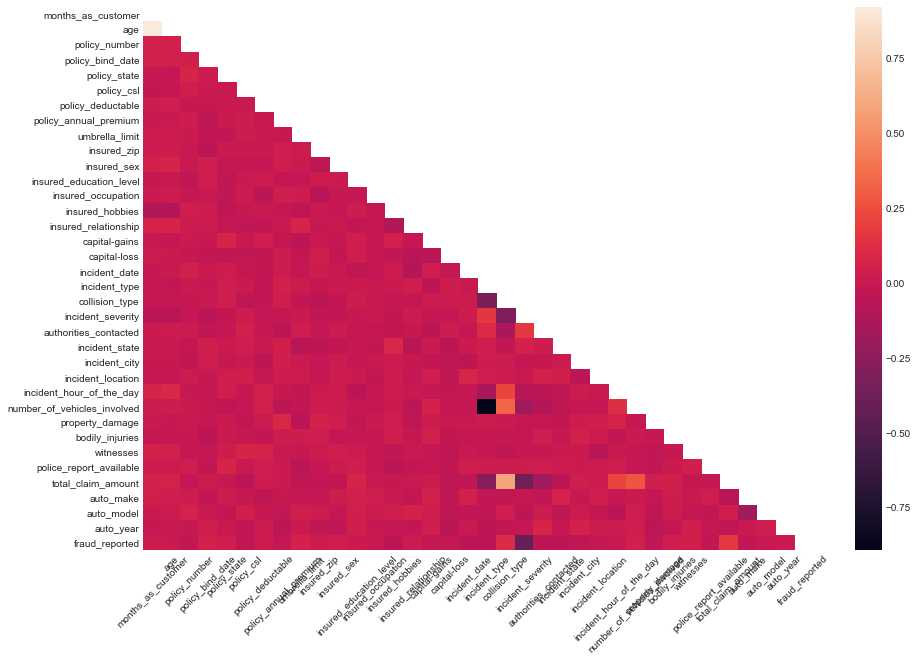

In [6]:
plt.figure(figsize=(15,10)) 
mask = np.triu(np.ones_like(data.corr()))
dataplot = sns.heatmap(data.corr(), mask=mask)
plt.xticks(rotation=45)
plt.show()

In [7]:
X = data.drop(['fraud_reported'], axis = 1)
y = data['fraud_reported']

In [10]:
(data[data['fraud_reported']==1].shape[0],
data[data['fraud_reported']==0].shape[0])

(247, 753)

# Как работают без улучшений

# SVM with SGD



In [11]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RANDOM_SEED)


In [12]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss = 'squared_hinge',penalty = 'elasticnet',class_weight = {0:0.25,1:0.75},random_state = RANDOM_SEED)
model.fit(X_train,y_train)

y_predict = model.predict(X_train)


print('Для тренировочных данных')
print(f'Accuracy: {metrics.accuracy_score(y_train,y_predict):2}')
print(f'F1-Score: {metrics.f1_score(y_train, y_predict):2}')
print(f'ROC_AUC: {metrics.roc_auc_score(y_train,y_predict)}')


Для тренировочных данных
Accuracy: 0.3171428571428571
F1-Score: 0.4054726368159204
ROC_AUC: 0.5378040762656148


In [13]:
y_predict = model.predict(X_test)
y_predict[y_predict==-1] = 0

print(f'Accuracy: {metrics.accuracy_score(y_test,y_predict)}')
print(f'F1-Score: {metrics.f1_score(y_test, y_predict)}')
print(f'ROC_AUC: {metrics.roc_auc_score(y_test,y_predict)}')

svm_accuracy,svm_gini = metrics.accuracy_score(y_test,y_predict),metrics.roc_auc_score(y_test,y_predict)
svm_f1 = metrics.f1_score(y_test, y_predict)

Accuracy: 0.33666666666666667
F1-Score: 0.4394366197183099
ROC_AUC: 0.5518018018018018


In [14]:
from numpy import mean
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
svm_gini = mean(scores)
print('Mean ROC AUC: %.3f' % (svm_gini))
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
svm_f1 = mean(scores)
print('Mean F1: %.3f' % (svm_f1))
print('-'*20)

Mean ROC AUC: 0.543
Mean F1: 0.320
--------------------


In [15]:
# from sklearn.svm import OneClassSVM

# model = svm.OneClassSVM()
# model.fit(X_train,y_train)
# y_predict = model.predict(X_train)
# y_predict[y_predict==-1] = 0
# print('Для тренировочных данных')
# print(f'Accuracy: {metrics.accuracy_score(y_train,y_predict)}')
# print(f'F1-Score: {metrics.f1_score(y_train, y_predict)}')
# print(f'ROC_AUC: {metrics.roc_auc_score(y_train,y_predict)}')

In [16]:
# y_predict = model.predict(X_test)
# y_predict[y_predict==-1] = 0


In [17]:

# print(f'Accuracy: {metrics.accuracy_score(y_test,y_predict)}')
# print(f'F1-Score: {metrics.f1_score(y_test, y_predict)}')
# print(f'ROC_AUC: {metrics.roc_auc_score(y_t,y_predict)}')

# svm_accuracy,svm_gini = metrics.accuracy_score(y_test,y_predict),2*metrics.roc_auc_score(y_test,y_predict) - 1
# svm_f1 = metrics.f1_score(y_test, y_predict)


# Random Forest

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RANDOM_SEED)

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(criterion='gini',class_weight = {0:70,1:30})

In [20]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 70, 1: 30})

In [21]:
y_predict = rf_model.predict(X_train)
print('Для тренировочных данных')
print(f'Accuracy: {metrics.accuracy_score(y_train,y_predict)}')
print(f'F1-Score: {metrics.f1_score(y_train, y_predict)}')
print(f'ROC-AUC: {metrics.roc_auc_score(y_train,y_predict) }')


Для тренировочных данных
Accuracy: 1.0
F1-Score: 1.0
ROC-AUC: 1.0


In [22]:
y_predict = rf_model.predict(X_test)
print(f'Accuracy: {metrics.accuracy_score(y_test,y_predict)}')
print(f'ROC-AUC: {metrics.roc_auc_score(y_test,y_predict) }')
print(f'F1-Score: {metrics.f1_score(y_test, y_predict)}')
rf_accuracy,rf_gini = metrics.accuracy_score(y_test,y_predict),metrics.roc_auc_score(y_test,y_predict)
rf_f1 = metrics.f1_score(y_test, y_predict)

Accuracy: 0.7866666666666666
ROC-AUC: 0.647955647955648
F1-Score: 0.4666666666666667


In [23]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
scores = cross_val_score(rf_model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
rf_gini = mean(scores)
print('Mean ROC AUC: %.3f' % (rf_gini))
scores = cross_val_score(rf_model, X, y, scoring='f1', cv=cv, n_jobs=-1)
rf_f1 = mean(scores)
print('Mean F1: %.3f' % (rf_f1))
print('-'*20)

Mean ROC AUC: 0.843
Mean F1: 0.498
--------------------


# DNN

In [24]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 90)

In [25]:
# from sklearn.neural_network import MLPClassifier
# dnn_model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(3, 2), random_state=90)
# # 

In [26]:
# dnn_model.fit(X_train,y_train)

In [27]:

# # y_predict = dnn_model.predict(X_train)
# print('Для тренировочных данных')
# print(f'Accuracy: {metrics.accuracy_score(y_train,y_predict)}')
# print(f'F1-Score: {metrics.f1_score(y_train, y_predict)}')
# print(f'Gini: {2*metrics.roc_auc_score(y_train,y_predict) - 1}')


In [28]:
# print('Для тестовых данных')
# y_predict = dnn_model.predict(X_test)
# print(f'Accuracy: {metrics.accuracy_score(y_test,y_predict)}')
# print(f'Gini: {2*metrics.roc_auc_score(y_test,y_predict) - 1}')
# print(f'F1-Score: {metrics.f1_score(y_test, y_predict)}')
# dnn_accuracy,dnn_gini = metrics.accuracy_score(y_test,y_predict), 2*metrics.roc_auc_score(y_test,y_predict) - 1
# dnn_f1 = metrics.f1_score(y_test, y_predict)







# Gradient Boosting Classifier

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

In [30]:
gb_model = GradientBoostingClassifier(n_estimators = 10, random_state = RANDOM_SEED)

In [31]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
scores = cross_val_score(gb_model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
score = mean(scores)
score

0.8725630116959064

In [32]:
gb_model.fit(X_train,y_train)

GradientBoostingClassifier(n_estimators=10, random_state=67)

In [33]:
y_predict = gb_model.predict(X_train)
print('Для тренировочных данных')
print(f'Accuracy: {metrics.accuracy_score(y_train,y_predict)}')
print(f'F1-Score: {metrics.f1_score(y_train, y_predict)}')
print(f'Gini: {metrics.roc_auc_score(y_train,y_predict)}')

Для тренировочных данных
Accuracy: 0.9
F1-Score: 0.7697368421052632
Gini: 0.8292046936114732


In [34]:
y_predict = gb_model.predict(X_test)
print(f'Accuracy: {metrics.accuracy_score(y_test,y_predict)}')
print(f'ROC-AUC: {metrics.roc_auc_score(y_test,y_predict) }')
print(f'F1-Score: {metrics.f1_score(y_test, y_predict)}')
gb_accuracy,gb_gini = metrics.accuracy_score(y_test,y_predict), metrics.roc_auc_score(y_test,y_predict) 
gb_f1 = metrics.f1_score(y_test,y_predict)

Accuracy: 0.8066666666666666
ROC-AUC: 0.703049203049203
F1-Score: 0.5671641791044776


In [35]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
scores = cross_val_score(gb_model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
gb_gini = mean(scores)
print('Mean ROC AUC: %.3f' % (gb_gini))
scores = cross_val_score(gb_model, X, y, scoring='f1', cv=cv, n_jobs=-1)
gb_f1 = mean(scores)
print('Mean F1: %.3f' % (rf_f1))
print('-'*20)

Mean ROC AUC: 0.873
Mean F1: 0.498
--------------------


# Logreg

In [36]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(class_weight = {0:0.70,1:0.30},solver = 'liblinear',multi_class = 'ovr')

In [37]:
lr_model.fit(X_train,y_train)

LogisticRegression(class_weight={0: 0.7, 1: 0.3}, multi_class='ovr',
                   solver='liblinear')

In [38]:
y_predict = lr_model.predict(X_train)
print('Для тренировочных данных')
print(f'Accuracy: {metrics.accuracy_score(y_train,y_predict)}')
print(f'F1-Score: {metrics.f1_score(y_train, y_predict)}')
print(f'Gini: {2*metrics.roc_auc_score(y_train,y_predict) - 1}')

Для тренировочных данных
Accuracy: 0.7585714285714286
F1-Score: 0.0
Gini: 0.0


In [39]:
y_predict = lr_model.predict(X_test)
print(f'Accuracy: {metrics.accuracy_score(y_test,y_predict)}')
print(f'Gini: {2*metrics.roc_auc_score(y_test,y_predict) - 1}')
print(f'F1-Score: {metrics.f1_score(y_test, y_predict)}')
lr_accuracy,lr_gini = metrics.accuracy_score(y_test,y_predict), 2*metrics.roc_auc_score(y_test,y_predict) - 1
lr_f1 = metrics.f1_score(y_test, y_predict)

Accuracy: 0.74
Gini: 0.0
F1-Score: 0.0


## Результаты в лоб на тестовых данных

In [40]:
methods = ['SVM','RF','DNN','GB','LR']
table = {i: [str(i)+'_accuracy',str(i)+'_gini',str(i)+'_f1'] for i in list(map(lambda x:x.lower(),methods))}

for method in table:
    metrics_array = []
    for metric_name in table[method]:
        metrics_array.append(locals().get(metric_name))
    table[method] = metrics_array
tabled = pd.DataFrame(table, index = ['accuracy','ROC_AUC','f1'])

tabled.drop(['dnn','lr'],axis = 1,inplace = True)
tabled.drop(['accuracy'])

,svm,rf,gb
ROC_AUC,0.543295,0.842511,0.872563
f1,0.320464,0.497560,0.564818


# Снижаем размерность с помощью PCA

In [41]:
# #сначала было 35 столбцов, давайте сделаем 10
# from sklearn.decomposition import PCA
# pca = PCA(n_components = 10)

In [42]:
# X_pca = pca.fit_transform(X)

In [43]:
# X_pca.shape

In [44]:
# from sklearn import svm
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, random_state = 72)

# model = svm.SVC(kernel = 'linear')
# model.fit(X_train,y_train)
# y_pred = model.predict(X_test)

In [45]:
# y_train[y_train['fraud_reported']==1]

In [46]:
sum(y_train/len(y_train))

0.24142857142857077

In [47]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# parameters = {'n_estimators': [i for i in range(10,205,5)],
#               'max_depth': [j for j in range(2,12,1)],
#               'max_features': [k for k in range(2,7,1)]}
# rf_model = RandomForestClassifier(class_weight = {0:70,1:30})
# CV_rf_model = GridSearchCV(rf_model,parameters,scoring = 'f1')


In [48]:
# CV_rf_model.fit(X_train,y_train)

In [49]:
# CV_rf_model.get_params()

# SMOT

In [50]:
# from sklearn.datasets import make_classification
X = data.drop(['fraud_reported'], axis = 1).values
y = data['fraud_reported']

In [51]:
# check version number
import imblearn
print(imblearn.__version__)

0.8.0


Counter({0: 753, 1: 247})


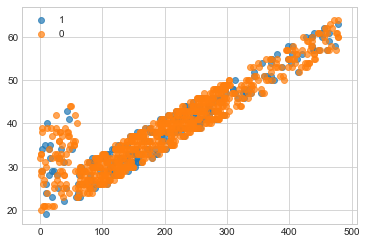

In [52]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = np.where(y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label), alpha = 0.7)
plt.legend()
plt.show()

In [53]:
from imblearn.over_sampling import SMOTE

Counter({0: 753, 1: 247})
Counter({1: 753, 0: 753})


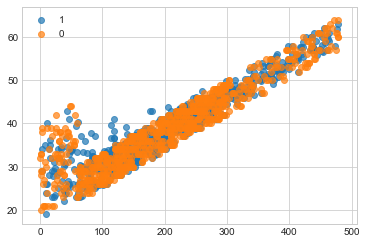

In [54]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
# define dataset
X = data.drop(['fraud_reported'], axis = 1).values
y = data['fraud_reported']
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label), alpha = 0.7)
pyplot.legend()
pyplot.show()

In [55]:
# decision tree evaluated on imbalanced dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

# define dataset
X = data.drop(['fraud_reported'], axis = 1).values
y = data['fraud_reported']
# define model
model =  SGDClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.514


In [56]:
# decision tree  on imbalanced dataset with SMOTE oversampling and random undersampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset
X = data.drop(['fraud_reported'], axis = 1).values
y = data['fraud_reported']
# define pipeline
model =  SGDClassifier(random_state = RANDOM_SEED)
over = SMOTE(sampling_strategy=0.5)
# under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.545


In [57]:
# decision tree  on imbalanced dataset with SMOTE oversampling and random undersampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
# define dataset
X = data.drop(['fraud_reported'], axis = 1).values
y = data['fraud_reported']
# define pipeline
model =  SGDClassifier()
over = SMOTE()
under = NearMiss(version = 1)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % max(scores))

Mean ROC AUC: 0.742


# <mark>SVM SGD </mark>

# Без Андерсамплинга

In [13]:
from numpy import mean
from statistics import median
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
def SMOTE_pipeline(model,X,y):
    k_values = [1, 2, 3, 4, 5, 6, 7]
    for k in k_values:
        # define pipeline
        over = SMOTE(k_neighbors=k)
        steps = [('over', over), ('model', model)]
        pipeline = Pipeline(steps=steps)
        # evaluate pipeline
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_SEED)
        scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
        mean_score = mean(scores)
        median_score = median(scores)
        print('> k=%d, Mean ROC AUC: %.3f, Median ROC AUC: %3f' % (k, mean_score, median_score))
        scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
        mean_score = mean(scores)
        median_score = median(scores)
        print('> k=%d, Mean F1: %.3f Median F1: %3f' % (k, mean_score, median_score))
        print('-'*20)  

In [14]:
model = SGDClassifier(random_state = RANDOM_SEED)
SMOTE_pipeline(model,X,y)

> k=1, Mean ROC AUC: 0.525, Median ROC AUC: 0.529067
> k=1, Mean F1: 0.249 Median F1: 0.307692
--------------------
> k=2, Mean ROC AUC: 0.536, Median ROC AUC: 0.537370
> k=2, Mean F1: 0.358 Median F1: 0.387597
--------------------
> k=3, Mean ROC AUC: 0.539, Median ROC AUC: 0.542371
> k=3, Mean F1: 0.301 Median F1: 0.344828
--------------------
> k=4, Mean ROC AUC: 0.538, Median ROC AUC: 0.537600
> k=4, Mean F1: 0.273 Median F1: 0.273684
--------------------
> k=5, Mean ROC AUC: 0.549, Median ROC AUC: 0.545749
> k=5, Mean F1: 0.327 Median F1: 0.352381
--------------------
> k=6, Mean ROC AUC: 0.523, Median ROC AUC: 0.526133
> k=6, Mean F1: 0.233 Median F1: 0.292135
--------------------
> k=7, Mean ROC AUC: 0.533, Median ROC AUC: 0.536533
> k=7, Mean F1: 0.314 Median F1: 0.385965
--------------------


# С Андерсамплингом

In [15]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
def SMOTE_under_pipeline(model,under,X,y):
    # define pipeline
    over = SMOTE(k_neighbors=k)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_SEED)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    mean_score = mean(scores)
    median_score = median(scores)
    print('> k=%d, Mean ROC AUC: %.3f, Median ROC AUC: %3f' % (k, mean_score, median_score))
    scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
    mean_score = mean(scores)
    median_score = median(scores)
    print('> k=%d, Mean F1: %.3f Median F1: %3f' % (k, mean_score, median_score))
    print('-'*20)

In [16]:
from sklearn.linear_model import SGDClassifier
k_values = [1, 2, 3, 4, 5, 6, 7, 8]
model = SGDClassifier()
for k in k_values:
    under = NearMiss(version = 1, n_neighbors = k)
    SMOTE_under_pipeline(model,under,X,y)



> k=1, Mean ROC AUC: 0.543, Median ROC AUC: 0.557067
> k=1, Mean F1: 0.286 Median F1: 0.351220
--------------------
> k=2, Mean ROC AUC: 0.538, Median ROC AUC: 0.539938
> k=2, Mean F1: 0.292 Median F1: 0.352941
--------------------
> k=3, Mean ROC AUC: 0.570, Median ROC AUC: 0.567600
> k=3, Mean F1: 0.344 Median F1: 0.400000
--------------------
> k=4, Mean ROC AUC: 0.550, Median ROC AUC: 0.557237
> k=4, Mean F1: 0.316 Median F1: 0.372093
--------------------
> k=5, Mean ROC AUC: 0.544, Median ROC AUC: 0.552667
> k=5, Mean F1: 0.324 Median F1: 0.377622
--------------------
> k=6, Mean ROC AUC: 0.543, Median ROC AUC: 0.556021
> k=6, Mean F1: 0.312 Median F1: 0.390476
--------------------
> k=7, Mean ROC AUC: 0.550, Median ROC AUC: 0.555210
> k=7, Mean F1: 0.295 Median F1: 0.377358
--------------------
> k=8, Mean ROC AUC: 0.541, Median ROC AUC: 0.546966
> k=8, Mean F1: 0.286 Median F1: 0.388350
--------------------


# <mark>Random Forest </mark>

In [17]:
model =  RandomForestClassifier(random_state = RANDOM_SEED)
SMOTE_pipeline(model,X,y)

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    under = NearMiss(version = 1, n_neighbors = k)
    SMOTE_under_pipeline(model,under,X,y)

# <mark> Gradient Boostig Classifier</mark>

In [ ]:
model =  GradientBoostingClassifier(random_state = RANDOM_SEED)
SMOTE_pipeline(model,X,y)

In [ ]:
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    under = NearMiss(version = 1, n_neighbors = k)
    SMOTE_under_pipeline(model,under,X,y)

In [ ]:
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    under = NearMiss(version = 2, n_neighbors = k)
    SMOTE_under_pipeline(model,under,X,y)

In [ ]:
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    under = NearMiss(version = 3, n_neighbors = k)
    SMOTE_under_pipeline(model,under,X,y)

In [ ]:
from imblearn.over_sampling import ADASYN
def SMOTE_under_pipeline(model,under,X,y):
    # define pipeline
    over = ADASYN()
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_SEED)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    mean_score = mean(scores)
    median_score = median(scores)
    print('> k=%d, Mean ROC AUC: %.3f, Median ROC AUC: %3f' % (k, mean_score, median_score))
    scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
    mean_score = mean(scores)
    median_score = median(scores)
    print('> k=%d, Mean F1: %.3f Median F1: %3f' % (k, mean_score, median_score))
    print('-'*20)

In [ ]:
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    under = NearMiss(version = 3, n_neighbors = k)
    SMOTE_under_pipeline(model,under,X,y)